In [ ]:
trainDataset="drive/MyDrive/twitter/onechunk/part-00000.lzo"

In [ ]:
%%capture
!pip install bert-for-tf2
!pip install sentencepiece
!pip install -q tensorflow-text
!pip install silence_tensorflow

In [ ]:
%%capture
!pip install transformers

#Move first chunk


In [ ]:
%%capture
!apt-get install lzop

In [ ]:
!cp "drive/MyDrive/twitter/onechunk/part-00000.lzo" file.lzo

In [ ]:
!lzop -x file.lzo
!mv file Dataset.csv

#Imports

In [ ]:
import silence_tensorflow.auto

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from tensorflow.keras import layers
import bert
import numpy as np
from transformers import BertTokenizer, TFBertModel, BertConfig,TFBertForSequenceClassification,TFDistilBertModel

from keras.layers.core import Dense,Activation,Dropout
from tensorflow.keras import regularizers

In [ ]:
import gc
import numpy as np
np.random.seed(1234)
gc.collect()
all_features = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "engaging_user_id", "engaging_user_follower_count", "engaging_user_following_count", "engaging_user_is_verified",\
               "engaging_user_account_creation", "engagee_follows_engager","reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]
all_features_to_idx = dict(zip(all_features, range(len(all_features))))

#Naive Implementation

##Work

###DatasetPreparation

In [ ]:
%%capture
import os, json, zipfile, shutil, platform, time

import scipy.sparse as sps
from pandas import DataFrame
import pandas as pd
import numpy as np

import multiprocessing
import multiprocessing.pool
import time

from random import randint
import gc

In [ ]:
train= pd.read_csv("Dataset.csv",sep='\x01',header=None)
train.columns=all_features

In [ ]:
train["text_len"]=train["text_tokens"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint16")


In [ ]:
train=train[train["text_len"]<=511].copy()
gc.collect()

0

In [ ]:


#tweet features (some must be added later)
train["retweet"]=train["tweet_type"].apply(lambda row: 1 if row=="Retweet" else 0)
train["quote"]=train["tweet_type"].apply(lambda row: 1 if row=="Quote" else 0)
train["top"]=train["tweet_type"].apply(lambda row: 1 if row=="Toplevel" else 0)

train.drop("tweet_type",axis=1,inplace=True)


train["text_len"]-=np.mean(train["text_len"].values)
train["text_len"]/=np.std(train["text_len"].values)

train.fillna(value={"hashtags":""},inplace=True)
train.fillna(value={"present_links":""},inplace=True)
train.fillna(value={"present_domains":""},inplace=True)
train.fillna(value={"present_media":""},inplace=True)

train["hashtags"]=train["hashtags"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["present_media"]=train["present_media"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["present_links"]=train["present_links"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["present_domains"]=train["present_domains"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["hashtags"]-=np.mean(train["hashtags"].values)
train["hashtags"]/=np.std(train["hashtags"].values)
train["present_media"]-=np.mean(train["present_media"].values)
train["present_media"]/=np.std(train["present_media"].values)
train["present_links"]-=np.mean(train["present_links"].values)
train["present_links"]/=np.std(train["present_links"].values)
train["present_domains"]-=np.mean(train["present_domains"].values)
train["present_domains"]/=np.std(train["present_domains"].values)

#Relation 
train["engagee_follows_engager"]=train["engagee_follows_engager"].apply(lambda row: 1 if row else 0).astype("uint8")
train["engaged_with_user_is_verified"]=train["engaged_with_user_is_verified"].apply(lambda row: 1 if row else 0).astype("uint8")
train["engaging_user_is_verified"]=train["engaging_user_is_verified"].apply(lambda row: 1 if row else 0).astype("uint8")

In [ ]:
train["like"]=train["like_timestamp"].apply(lambda row: 1 if row>0 else 0).astype("uint8")
train.drop("like_timestamp",axis=1,inplace=True)

In [ ]:
features=["text_tokens","retweet","quote","top", "hashtags","text_len", "present_media", "present_links", "present_domains",\
             "engaging_user_id",\
                "engaged_with_user_is_verified",\
                 "engaging_user_is_verified",\
             "engagee_follows_engager"]

In [ ]:
train["engaging_user_id"], uniques = pd.factorize(train["engaging_user_id"])

In [ ]:
temp=pd.DataFrame(train["engaging_user_id"]).copy()
temp["frequency"]=1
temp=temp.groupby("engaging_user_id").transform('sum')

In [ ]:
temp=temp[temp["frequency"]>=8]

In [ ]:
temp

,frequency
7,8
42,10
88,15
100,9
102,8
...,...
3033693,8
3033743,8
3033797,8
3033805,9


In [ ]:
train

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,text_len,retweet,quote,top,like
0,101\t56898\t137\t16925\t10731\t11481\t13980\t1...,-0.354747,5DCE3020423313CB0AC2631DEF94D2F5,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613237034,BC9980C5385A68894C2862F41884FB27,2473,662,0,1261859734,0,169,339,0,1520886748,0,NaN,NaN,NaN,0.144138,1,0,0,0
1,101\t10159\t11322\t58550\t10836\t10126\t25900\...,-0.354747,2B6F5C7C4F04F34543C09DD6E58C8F66,-0.621253,2.577894,2.577894,B0FA488F2911701DD8EC5B1EA5E322D8,1613748600,C0EBA033A5C0D2AD91B4500958E2C633,4418640,228,1,1266804490,1,393,1190,0,1237570695,0,NaN,NaN,NaN,1.099749,0,0,0,0
2,101\t10159\t56314\t14364\t10109\t14657\t11359\...,-0.354747,784D3AE5E6429392245BD34FF4C82B5C,-0.621253,2.577894,2.577894,B0FA488F2911701DD8EC5B1EA5E322D8,1613386238,03EA05E7440140ABF047BC216CE34917,219715,3685,1,1202617218,2,629,1473,0,1263176351,0,NaN,NaN,NaN,-0.231280,0,0,0,1
3,101\t56898\t137\t10224\t10731\t64194\t41939\t3...,-0.354747,CA49ACBB31921F2A0FAC1CCCC99541F6,-0.621253,-0.338471,-0.338471,B0FA488F2911701DD8EC5B1EA5E322D8,1613708640,2700B9E175757F126C082D6A5742787D,2388283,13511,1,1251645191,3,123,200,0,1268276559,0,NaN,NaN,NaN,-0.197151,1,0,0,0
4,101\t7143\t1938\t113\t100\t10097\t100\t10097\t...,-0.354747,2C95B42C651B36D84584F3653D722142,0.499838,-0.338471,-0.338471,E7F038DE3EAD397AEC9193686C911677,1612586018,B7E441F2D886830FB3F0CE29CB35CB6B,414,720,0,1578273274,4,134,379,0,1483862063,1,NaN,NaN,NaN,0.690202,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033897,101\t56898\t137\t40431\t14678\t11710\t12985\t1...,-0.354747,25B1D557E6B6D7298CA3888C72F9F7B5,-0.621253,-0.338471,-0.338471,B8B04128918BBF54E2E178BFF1ABA833,1612804061,D61350A37DDC6E19AD5B1D44C607FF7D,2230,2332,0,1562591414,2174192,254,342,0,1505241576,1,NaN,NaN,NaN,-0.026507,1,0,0,0
3033898,101\t10747\t57667\t10123\t10124\t30776\t20149\...,-0.354747,3A656480D09FCCBA39B0E28FBFA64B72,0.499838,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613964078,9009A33FB64F15F71D689C46FD40DA0E,90842,687,0,1591895377,2174193,238,511,0,1587168543,0,1.613964e+09,NaN,NaN,-0.743215,0,0,0,0
3033899,101\t56898\t137\t10211\t10589\t21428\t12620\t1...,-0.354747,E236B2359B119B2A7668FA83AC5E750B,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1614124187,57F1EBC5767EA3F7CE3EEDB6EAE9B097,608,328,0,1341523778,2174194,814,803,0,1336720553,1,NaN,NaN,NaN,-0.709086,1,0,0,0
3033900,101\t19561\t10605\t97764\t10729\t64008\t30297\...,-0.354747,B42CB5B47ABCCA8700686CD8F32696B6,-0.621253,-0.338471,-0.338471,B0FA488F2911701DD8EC5B1EA5E322D8,1613329929,D3D9F1F6F4CCFA079891511B0818FF03,6777417,888,1,1263785737,2174195,27,83,0,1540658011,0,NaN,NaN,NaN,-1.255149,0,0,0,1


In [ ]:
gc.collect()

65

In [ ]:
temp['engaging_user_id'] = temp.index

In [ ]:
temp.head()

,frequency,engaging_user_id
7,8,7
42,10,42
88,15,88
100,9,100
102,8,102


In [ ]:
train=train.merge(temp,how="left",on="engaging_user_id")

In [ ]:
train = train[train['frequency']>0]

In [ ]:
train

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,text_len,retweet,quote,top,like,frequency
7,101\t164\t100\t166\t47464\t17734\t10114\t11850...,-0.354747,787DEDA041736D0B55A0C15E993682C1,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1614132656,223797E039AFAC669C3A24A43B59CD5E,209681,141,0,1516334262,7,35,106,0,1581377629,0,NaN,NaN,NaN,-0.572570,0,1,0,1,8.0
42,101\t15764\t10700\t763\t24455\t17329\t19163\t1...,-0.354747,9B25FA25E79D31D3BCC37C45F4C731E5,-0.621253,-0.338471,-0.338471,9A78FC330083E72BE0DD1EA92656F3B5,1612472571,A5A49E65DE6B45652AFCA96BB96EB7D0,15152,1563,0,1427441187,42,167,394,0,1546022960,1,NaN,NaN,NaN,-1.152762,0,0,0,1,10.0
88,101\t100\t14120\t131\t120\t120\t188\t119\t1117...,-0.354747,23EED02EF54627746864178BEC619BAB,0.499838,-0.338471,-0.338471,313ECD3A1E5BB07406E4249475C2D6D6,1613219107,6F20AD7BE5CFA479678F28F4D8DF7EED,151,254,0,1599062672,88,799,958,0,1599118585,1,NaN,NaN,NaN,-0.879731,0,0,0,1,15.0
100,101\t10117\t10817\t10124\t16683\t10452\t89025\...,-0.354747,0B8A89DC11512E31049B6A7225F86531,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1612663152,5C5AAD876AB3B53AB1E70E77C9324EAA,35474,1938,1,1356917793,100,424,493,0,1169766828,0,NaN,NaN,NaN,-0.572570,0,0,0,1,9.0
102,101\t14962\t10114\t29922\t10105\t14428\t26623\...,-0.354747,803258AB3CE7D4F7971B634D79D96BA6,-0.621253,2.577894,2.577894,488B32D24BD4BB44172EB981C1BCA6FA,1613505146,9C0302E820C42214B6678FB77E1CF4D2,7620139,1730,1,1232922624,102,200,335,0,1344541813,0,NaN,NaN,NaN,-0.504312,0,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033821,101\t17073\t146\t19556\t169\t12229\t55785\t419...,-0.354747,ECF31ED9BC29E57064DEDF7647DCDBFC,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613887057,31009B27BF3B4BF8C87588C0E0C2924B,2245,716,0,1233876885,2174144,766,412,0,1326762970,1,NaN,NaN,NaN,-0.777344,0,0,0,0,12.0
3033838,101\t56898\t137\t67952\t98486\t10157\t63615\t1...,-0.354747,D3E2FE3908C4D90CE784E852D4B7E2FE,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613589544,0F322FA675F4E0A8AB685E97BC9351A1,237,139,0,1380646920,2174156,61,82,0,1535477278,0,NaN,NaN,NaN,-0.845602,1,0,0,1,9.0
3033845,101\t36448\t13013\t11559\t10126\t33478\t13904\...,-0.354747,82EDEC74FCC1E0276B8C1FC946949E5D,-0.621253,-0.338471,-0.338471,B8B04128918BBF54E2E178BFF1ABA833,1613320217,CDDD553B7B28EAEC321E2F2E65DBBAC8,34485,95,0,1296677208,78332,140,686,0,1409997952,0,NaN,NaN,NaN,-0.811473,0,0,0,1,8.0
3033856,101\t108\t177\t57277\t69196\t12396\t33893\t722...,7.709830,A131922DCE502E5CE7FF5737BEF3F285,0.499838,-0.338471,-0.338471,8729EBF694C3DAF61208A209C2A542C8,1613897121,F7A7DB4563C6177579D581CE80D4F24D,1029865,11,1,1437139395,2174166,47,153,0,1517834704,0,NaN,NaN,NaN,1.509297,0,0,0,1,8.0


In [ ]:
train[train["engaging_user_id"]==7]

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,text_len,retweet,quote,top,like,frequency
7,101\t164\t100\t166\t47464\t17734\t10114\t11850...,-0.354747,787DEDA041736D0B55A0C15E993682C1,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1614132656,223797E039AFAC669C3A24A43B59CD5E,209681,141,0,1516334262,7,35,106,0,1581377629,0,NaN,NaN,NaN,-0.572570,0,1,0,1,8.0
543445,101\t56898\t137\t148\t42031\t15417\t19088\t114...,-0.354747,29847B144E32F30C5C2DD16CDC1EF259,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613748193,3C89DB0BFC4D0207969515683D8A1058,607730,104,0,1400243591,7,35,106,0,1581377629,0,NaN,1.613749e+09,NaN,0.348912,1,0,0,0,8.0
680439,101\t58573\t131\t137\t193\t22500\t168\t14731\t...,0.541317,55EA3882CDC9369BF9A5344D76F6C5EC,0.499838,-0.338471,-0.338471,8729EBF694C3DAF61208A209C2A542C8,1612917000,1E4380A3AE8DBCD4E16BE7815A826FBA,341445,206,0,1461311652,7,35,106,0,1581377629,0,NaN,NaN,NaN,2.601423,0,0,0,1,8.0
1369403,101\t100\t14120\t131\t120\t120\t188\t119\t1117...,-0.354747,AE62799DC2A663D542FB92AAF531E5D1,0.499838,-0.338471,-0.338471,313ECD3A1E5BB07406E4249475C2D6D6,1612752917,4E94CC63145741EC47F0B7F657202BA6,32807755,141,1,1305959576,7,35,106,0,1581377629,0,NaN,NaN,NaN,-0.879731,0,0,0,1,8.0
1900419,101\t56898\t137\t66238\t11127\t46382\t131\t827...,0.541317,48473E29DD77282DC875E137BA01A140,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613832624,167DA54259962F752BB57CDADDC49D89,141736,54,0,1543333956,7,35,106,0,1581377629,0,NaN,NaN,NaN,0.212396,1,0,0,1,8.0
2421270,101\t164\t10109\t91113\t12536\t10113\t168\t181...,1.437381,C39BF4C5EAA5E25BC0717E2D45432192,0.499838,-0.338471,-0.338471,5A0759FB938B1D9B1E08B7A3A14F1042,1614179521,23592AA28F01AB84FC2D4C6C5EB8B996,70677,46,0,1566458680,7,35,106,0,1581377629,0,NaN,1.614180e+09,NaN,1.168007,0,0,0,1,8.0
2617249,101\t97362\t48281\t106433\t10415\t10462\t131\t...,-0.354747,D8B794EE89D63F3D0AAF4336A919A336,-0.621253,2.577894,2.577894,488B32D24BD4BB44172EB981C1BCA6FA,1613501715,CE13D4ACB25B483D0B32E866E406BCFF,50701,76,0,1463690469,7,35,106,0,1581377629,0,NaN,NaN,NaN,0.212396,0,0,0,1,8.0
2687647,101\t100\t196\t27277\t49248\t32992\t82834\t358...,0.541317,DA815D8556F98F0271D1D2E516B52AB4,0.499838,2.577894,2.577894,488B32D24BD4BB44172EB981C1BCA6FA,1612854213,F3115402B4DD8515B5A7E595AF752F09,53630,64,0,1554606279,7,35,106,0,1581377629,0,NaN,NaN,NaN,2.362521,0,0,0,1,8.0


In [ ]:
msk = np.random.rand(len(train)) < 0.8
test=train[~msk]
train=train[msk]

In [ ]:
target=train["like"].values
targetTest=test["like"].values
gc.collect()

50

In [ ]:
for col in train.columns:
    if col not in features:
        train.drop(col,axis=1,inplace=True)
        test.drop(col,axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train.columns

Index(['text_tokens', 'hashtags', 'present_media', 'present_links',
       'present_domains', 'engaged_with_user_is_verified', 'engaging_user_id',
       'engaging_user_is_verified', 'engagee_follows_engager', 'text_len',
       'retweet', 'quote', 'top'],
      dtype='object')

In [ ]:
train=train[['text_tokens', 'hashtags', 'present_media', 'present_links',
       'present_domains', 'text_len',
       'retweet', 'quote', 'top',
       'engaging_user_is_verified', 'engagee_follows_engager','engaged_with_user_is_verified',  'engaging_user_id']]
test=test[['text_tokens', 'hashtags', 'present_media', 'present_links',
       'present_domains', 'text_len',
       'retweet', 'quote', 'top',
       'engaging_user_is_verified', 'engagee_follows_engager','engaged_with_user_is_verified',  'engaging_user_id']]

In [ ]:
train.head()

,text_tokens,hashtags,present_media,present_links,present_domains,text_len,retweet,quote,top,engaging_user_is_verified,engagee_follows_engager,engaged_with_user_is_verified,engaging_user_id
7,101\t164\t100\t166\t47464\t17734\t10114\t11850...,-0.354747,-0.621253,-0.338471,-0.338471,-0.572570,0,1,0,0,0,0,7
42,101\t15764\t10700\t763\t24455\t17329\t19163\t1...,-0.354747,-0.621253,-0.338471,-0.338471,-1.152762,0,0,0,0,1,0,42
88,101\t100\t14120\t131\t120\t120\t188\t119\t1117...,-0.354747,0.499838,-0.338471,-0.338471,-0.879731,0,0,0,0,1,0,88
100,101\t10117\t10817\t10124\t16683\t10452\t89025\...,-0.354747,-0.621253,-0.338471,-0.338471,-0.572570,0,0,0,0,0,1,100
102,101\t14962\t10114\t29922\t10105\t14428\t26623\...,-0.354747,-0.621253,2.577894,2.577894,-0.504312,0,0,0,0,0,1,102


In [ ]:
test.head()

,text_tokens,hashtags,present_media,present_links,present_domains,text_len,retweet,quote,top,engaging_user_is_verified,engagee_follows_engager,engaged_with_user_is_verified,engaging_user_id
161,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,-0.354747,3.863112,-0.338471,-0.338471,-0.913860,0,0,0,0,1,0,161
163,101\t752\t216\t775\t105563\t105563\t105563\t10...,0.541317,-0.621253,-0.338471,-0.338471,0.144138,0,0,0,0,1,0,163
174,101\t56898\t137\t10105\t17353\t42241\t10219\t1...,1.437381,-0.621253,-0.338471,-0.338471,0.212396,1,0,0,0,1,0,174
376,101\t2072\t2179\t4340\t216\t216\t108\t7143\t19...,0.541317,1.620930,-0.338471,-0.338471,-0.197151,0,0,0,0,1,0,376
401,101\t100\t216\t108\t1915\t26554\t38352\t64126\...,1.437381,0.499838,-0.338471,-0.338471,-0.231280,0,0,0,0,0,0,401


In [ ]:
train['engaging_user_id'].nunique()

70899

In [ ]:
test['engaging_user_id'].nunique()

21335

In [ ]:
gc.collect()

226

In [ ]:
input=train.values
inputTest=test.values

In [ ]:
import random
idx=0

#random.Random(idx).shuffle(input)
#random.Random(idx).shuffle(target)

###Model Definition

In [ ]:
NUM_TOKENS=511
NUM_FEATURES=8
REL_FEATURES=3
EMB_SIZE=64
EMBEDDING_INPUT_SIZE=len(uniques)+1

In [ ]:
config = BertConfig.from_pretrained("bert-base-multilingual-cased", output_hidden_states=False)

In [ ]:
#encoder = TFBertModel.from_pretrained('bert-base-multilingual-cased', config=config)
#encoder = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', config=config)
encoder = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
encoder.trainable=False

In [ ]:
input_ids = layers.Input(shape=(NUM_TOKENS,), dtype=tf.int32,name="tokens")
attention_mask = layers.Input(shape=(NUM_TOKENS,), dtype=tf.int32,name="mask")
#embedding = encoder(       {"input_ids":input_ids,"attention_mask":attention_mask})[1]
embedding = encoder(       {"input_ids":input_ids,"attention_mask":attention_mask})[0]
#encoder({"input_ids":input_ids,"attention_mask":attention_mask})

#embeddingFixed=layers.Flatten()(embedding)
embeddingFixed=layers.GlobalAveragePooling1D()(embedding)


In [ ]:
inputs1 = layers.Dense(EMB_SIZE, name="emb_text",activation="relu")(embeddingFixed)

inputs2 = layers.Input(shape=(NUM_FEATURES,), name="tweet_features")
inputs3 = layers.Input(shape=(REL_FEATURES,), name="relationship_features")
inputs4 = layers.Input(shape=(1,), name="userId")
#emb_init=tf.keras.initializers.Zeros()
#emb_init=tf.keras.initializers.glorot_normal(seed=1)
emb_init=tf.keras.initializers.Constant(0.01)

user_emb = layers.Embedding(EMBEDDING_INPUT_SIZE, EMB_SIZE, input_length=1,embeddings_initializer=emb_init)(inputs4)
user_emb_flat = layers.Flatten()(user_emb)
concat = layers.Concatenate()([inputs1,inputs2,inputs3,user_emb_flat])

#concat = layers.Concatenate()([embeddingFixed,inputs2,inputs3,user_emb_flat])

hiddenLayer= layers.Dense(64,activation="relu")(concat)
drop=layers.Dropout(0.5)(hiddenLayer)
out=layers.Dense(1,kernel_regularizer=regularizers.l2(1e-4),activation="sigmoid")(drop)

In [ ]:
#model=keras.Model(inputs=[input_ids,inputs2,inputs3,inputs4], outputs=out, name="NN")
model=keras.Model(inputs=[input_ids,attention_mask,inputs2,inputs3,inputs4], outputs=out, name="NN")
model2=keras.Model(inputs=[inputs4],outputs=user_emb_flat)

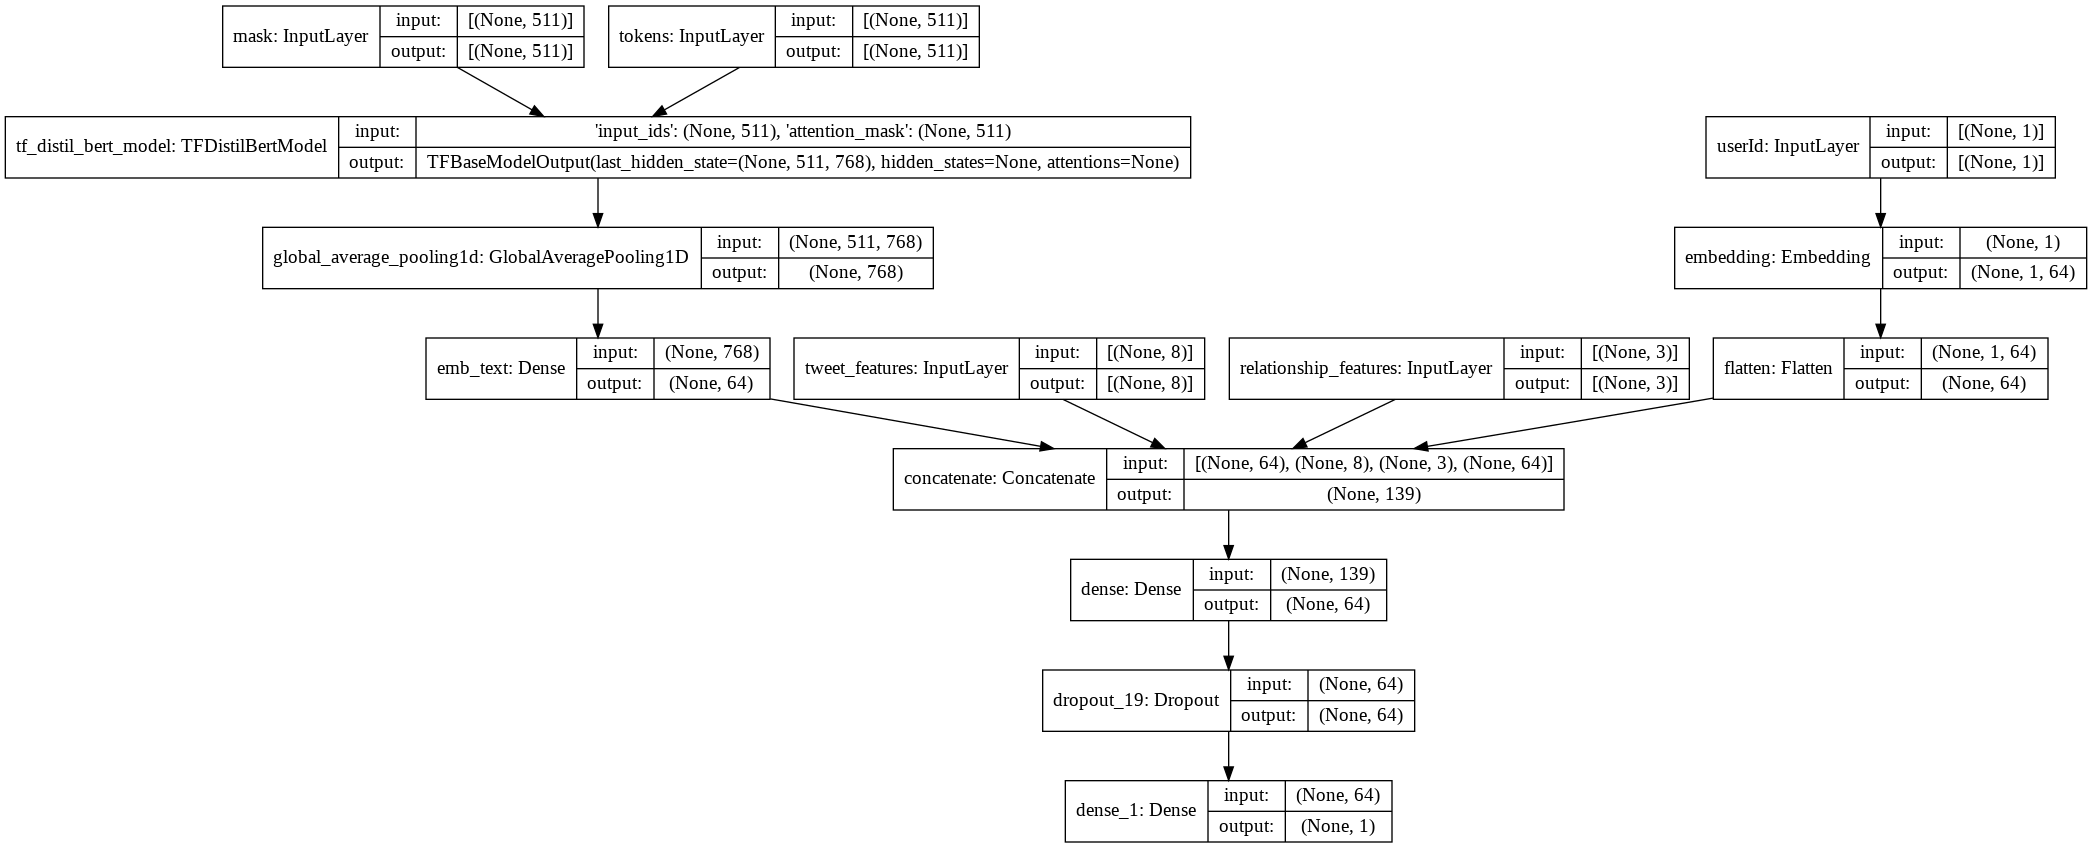

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

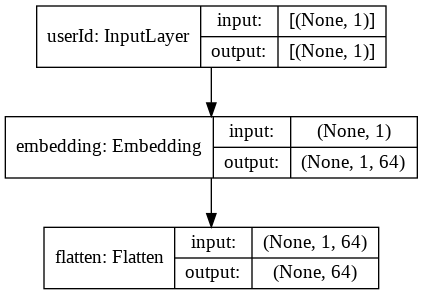

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
text=[101,3653,1291,102]+[0]*(NUM_TOKENS-4)
def att(token):
    return 0 if token==0 else 1
attention=[att(t) for t in text]

In [ ]:
model([tf.constant(text,shape=(1,NUM_TOKENS)),tf.constant(attention,shape=(1,NUM_TOKENS)),tf.constant([0]*NUM_FEATURES,shape=(1,NUM_FEATURES)),tf.constant([0]*REL_FEATURES,shape=(1,REL_FEATURES)),tf.constant(1,shape=(1,1))])
#model([tf.constant(text,shape=(1,NUM_TOKENS)),tf.constant([0]*NUM_FEATURES,shape=(1,NUM_FEATURES)),tf.constant([0]*REL_FEATURES,shape=(1,REL_FEATURES)),tf.constant([0]*EMB_SIZE,shape=(1,EMB_SIZE))])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48479447]], dtype=float32)>

In [ ]:
model2([tf.constant(0,shape=(1,1))])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]],
      dtype=float32)>

In [ ]:
model2([tf.constant(1,shape=(1,1))])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]],
      dtype=float32)>

###Model parameters

In [ ]:
import tensorflow.keras.backend as K

def create_weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
    return weighted_binary_crossentropy

In [ ]:
loss=create_weighted_binary_crossentropy(1, 3)
#loss=tf.keras.losses.BinaryCrossentropy()#   from_logits=True)
lr=0.0003
optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
train_acc_metric=tf.keras.metrics.AUC(curve="PR")
#train_acc_metric=tf.keras.metrics.BinaryCrossentropy(name="binary_crossentropy", dtype=None, from_logits=False, label_smoothing=0)
#train_acc_metric=tf.keras.metrics.MeanSquaredError()
#train_acc_metric=tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)
model.compile(loss=loss,optimizer=optimizer,metrics=train_acc_metric)

###Custom Dataset

####CreateDatasetObject

#####Old test version

In [ ]:
class DatasetFixed:
    def __init__(self):
        pass

    def __iter__(self):
        return self

    def __next__(self):
        return [tf.constant(text,shape=(1,NUM_TOKENS)),tf.constant(attention,shape=(1,NUM_TOKENS)),tf.constant([0]*NUM_FEATURES,shape=(1,NUM_FEATURES)),tf.constant([0]*REL_FEATURES,shape=(1,REL_FEATURES)),1]
        raise StopIteration

In [ ]:
train_dataset=DatasetFixed()

#####Correct version

In [ ]:

def generator(input,output):
    while True:
        for i in range(len(input)):
            row=input[i]
            out=output[i]
            text=[int(t) for t in row[0].split("\t")]
            att=([1]*len(text))+[0]*(NUM_TOKENS-len(text))
            text=text+[0]*(NUM_TOKENS-len(text))
            feats=[*row[1:9]]
            rel=[*row[9:12]]
            user=row[12]
            yield [tf.constant(text,shape=(1,NUM_TOKENS)),
                   tf.constant(att,shape=(1,NUM_TOKENS)),
                   tf.constant(feats,shape=(1,NUM_FEATURES)),
                   tf.constant(rel,shape=(1,REL_FEATURES)),
                   tf.constant(user,shape=(1,1)),
                   tf.constant(out,shape=(1,1),dtype=tf.float32)]
class DatasetFixed:
    def __init__(self,input,output):
        self.len=len(input)
        self.iteration=0
        self.gen=generator(input,output)

    def __iter__(self):
        return self

    def __next__(self):
        self.iteration+=1
        if self.iteration>self.len:
            self.iteration=0
            raise StopIteration
        return next(self.gen)
       

In [ ]:
train_dataset=DatasetFixed(input,target)

#####Single KerasCustomGenerator

In [ ]:
import numpy as np
import keras

class SingleDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,inputs, outputs,tweet_data_size,rel_data_size,num_tokens):
        'Initialization'
        self.inputs = inputs
        self.outputs = outputs
        self.length= len(inputs)
        self.tweet_data_size=tweet_data_size
        self.rel_data_size=rel_data_size
        self.num_tokens=num_tokens
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.length

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch

        # Find list of IDs

        # Generate data
        X, y = self.__data_generation(index)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        text_batch = np.empty((self.num_tokens))
        mask = np.empty((self.num_tokens))
        tweet = np.empty((self.tweet_data_size))
        rel = np.empty((self.rel_data_size))
        id = np.empty((1))
        y = np.empty((1), dtype=np.float32)

        # Generate data
        for i in [indexes]:
            row=self.inputs[i]
            text=[int(t) for t in row[0].split("\t")]
            
            pad=self.num_tokens-len(text)
            att=([1]*len(text))+[0]*(pad)
            text=text+([0]*(pad))

            feats=[*row[1:9]]
            relations=[*row[9:12]]
            user=row[12]
            i-=indexes[0]
            # Store sample
            text_batch = np.array(text)
            mask=np.array(att)
            tweet=np.array(feats)
            rel=np.array(relations)
            id=np.array(user)

            # Store class
            y[0] = self.outputs[i]

        return (text_batch,mask,tweet,rel,id), y

#####KerasCustomGenerator

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,inputs, outputs,tweet_data_size,rel_data_size,num_tokens, batch_size=32):
        'Initialization'
        self.batch_size = batch_size
        self.inputs = inputs
        self.outputs = outputs
        self.length= len(inputs)
        self.tweet_data_size=tweet_data_size
        self.rel_data_size=rel_data_size
        self.num_tokens=num_tokens
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.length / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = range(index*self.batch_size,(index+1)*self.batch_size)

        # Find list of IDs

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        text_batch = np.empty((self.batch_size,self.num_tokens))
        mask = np.empty((self.batch_size,self.num_tokens))
        tweet = np.empty((self.batch_size,self.tweet_data_size))
        rel = np.empty((self.batch_size,self.rel_data_size))
        id = np.empty((self.batch_size,1))
        y = np.empty((self.batch_size), dtype=np.float32)

        # Generate data
        for i in indexes:
            row=self.inputs[i]
            text=[int(t) for t in row[0].split("\t")]
            
            pad=self.num_tokens-len(text)
            att=([1]*len(text))+[0]*(pad)
            text=text+([0]*(pad))

            feats=[*row[1:9]]
            relations=[*row[9:12]]
            user=row[12]
            i-=indexes[0]
            # Store sample
            text_batch[i,] = np.array(text)
            mask[i,]=np.array(att)
            tweet[i,]=np.array(feats)
            rel[i,]=np.array(relations)
            id[i,]=np.array(user)

            # Store class
            y[i] = self.outputs[i]

        return (text_batch,mask,tweet,rel,id), y

##Training

###Fit

In [ ]:
gc.collect()

In [ ]:
BATCH_SIZE=128

In [ ]:
training_generator = DataGenerator(input[:len(input)], target[:len(input)],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)
test_generator = DataGenerator(inputTest[:len(inputTest)], targetTest[:len(inputTest)],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)

In [ ]:
training_generator.__getitem__(1)[0][0][0][0]

In [ ]:
model.fit(training_generator,epochs=1)

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.fit(training_generator,epochs=1)

In [ ]:
model.evaluate(test_generator)

In [ ]:
model2([tf.constant(0,shape=(1,1))])

In [ ]:
model2([tf.constant(1,shape=(1,1))])

###Try using sequence to get a tf.dataset

In [ ]:
BATCH_SIZE=128

In [ ]:
training_generator=SingleDataGenerator(input[:len(input)//10], target[:len(input)//10],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS)
data_iter = lambda: (s for s in training_generator )


# then you can use tf.data.Dataset.from_generator
dataset_tf = tf.data.Dataset.from_generator(
    data_iter,
    output_signature=(
                        (
                        tf.TensorSpec(shape=(511,), dtype=tf.float32),
                        tf.TensorSpec(shape=(511,), dtype=tf.float32),
                        tf.TensorSpec(shape=(training_generator.tweet_data_size,), dtype=tf.float32),
                        tf.TensorSpec(shape=(training_generator.rel_data_size,), dtype=tf.float32),
                        tf.TensorSpec(shape=(1,), dtype=tf.int32)
                        ),
                    tf.TensorSpec(shape=(1,), dtype=tf.float32, name='input_4')
                    ))

# now you can add a prefetch option that builds the next batch ready for consumption by the GPU as it is working on the current batch.
#dataset_tf = dataset_tf.prefetch(1)

NameError: ignored

In [ ]:
dataset_tf = dataset_tf.batch(BATCH_SIZE)

dataset_tf = dataset_tf.repeat()

In [ ]:
dataset_tf.take(1)

In [ ]:
gc.collect()

In [ ]:
import math

In [ ]:
steps=math.floor(len(training_generator)/BATCH_SIZE)

In [ ]:
model.fit(dataset_tf,steps_per_epoch=steps)

###batched generator version

In [ ]:
BATCH_SIZE=64

In [ ]:
training_generator = DataGenerator(input[:len(input)//2], target[:len(input)//2],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)

data_iter = lambda: (s for s in training_generator )

dataset_tf = tf.data.Dataset.from_generator(
    data_iter,
    output_signature=(
                        (
                        tf.TensorSpec(shape=(BATCH_SIZE,511), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,511), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,training_generator.tweet_data_size), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,training_generator.rel_data_size), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,1), dtype=tf.int32)
                        ),
                    tf.TensorSpec(shape=(BATCH_SIZE), dtype=tf.float32, name='input_4')
                    ))
dataset_tf = dataset_tf.prefetch(2)

In [ ]:
steps=len(training_generator)

In [ ]:
steps

741

In [ ]:
gc.collect()

272

In [ ]:
model.fit(dataset_tf,steps_per_epoch=steps)

741/741 [==============================] - 1710s 2s/step - loss: 0.6967 - auc: 0.5009


In [ ]:
test_generator = DataGenerator(inputTest[:len(inputTest)], targetTest[:len(inputTest)],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)


In [ ]:
model.evaluate(test_generator)

369/369 [==============================] - 447s 1s/step - loss: 0.6907 - auc: 0.5023


[0.6906828284263611, 0.5022758841514587]

In [ ]:
model.fit(dataset_tf,steps_per_epoch=steps)

741/741 [==============================] - 1708s 2s/step - loss: 0.6786 - auc: 0.6051


In [ ]:
model.evaluate(test_generator)

369/369 [==============================] - 445s 1s/step - loss: 0.6939 - auc: 0.5113


[0.6939453482627869, 0.5113154053688049]

In [ ]:
!kill -9 -1

###Custom Training loop

In [ ]:
@tf.function
def trainStep(text,att,features,rel,user,out):
    with tf.GradientTape() as tape:
        logits = model([text,att,features,rel,user], training=True)  # Logits for this minibatch
        loss_value = loss(out, logits)
            
    train_acc_metric.update_state(out, logits)
        
    grad = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grad, model.trainable_weights))
    return logits

In [ ]:
gc.collect()

28106

In [ ]:
epochs = 10
loss_value=10
train_dataset=DatasetFixed(input,target)
for epoch in range(epochs):
    train_acc_metric.reset_states()
    if loss_value<=0.01:
                break
    print("\nStart of epoch %d" % (epoch,))
    for step, (text,att,features,rel,engaged_Id,out) in enumerate(train_dataset):
        logits=trainStep(text,att,features,rel,engaged_Id,out)
        if step % 100 == 0:
            #print(model2(engaged_Id).numpy())
            train_acc = train_acc_metric.result()
            print(f"Training abs error at step {step}: {train_acc}")
            print(f"target{out.numpy()} => predict {logits.numpy()}")
            gc.collect()
    train_acc = train_acc_metric.result()
    print(f"Training abs error over epoch {epoch}: {train_acc}")
    train_acc_metric.reset_states()


Start of epoch 0
Training abs error at step 0: 0.48795750737190247
target[[0.]] => predict [[0.4879575]]
Training abs error at step 100: 0.4684427082538605
target[[1.]] => predict [[0.33095264]]
Training abs error at step 200: 0.4653521478176117
target[[0.]] => predict [[0.74113363]]
Training abs error at step 300: 0.47499024868011475
target[[1.]] => predict [[0.2997694]]
Training abs error at step 400: 0.4641820788383484
target[[1.]] => predict [[0.34601104]]
Training abs error at step 500: 0.46867963671684265
target[[1.]] => predict [[0.4215265]]
Training abs error at step 600: 0.4710558354854584
target[[0.]] => predict [[0.6465208]]
Training abs error at step 700: 0.4764944612979889
target[[0.]] => predict [[0.5367392]]
Training abs error at step 800: 0.4795038402080536
target[[0.]] => predict [[0.77697635]]


KeyboardInterrupt: ignored

#Precompute bert Implementation

##Work

###DatasetPreparation

In [ ]:
%%capture
import os, json, zipfile, shutil, platform, time

import scipy.sparse as sps
from pandas import DataFrame
import pandas as pd
import numpy as np

import multiprocessing
import multiprocessing.pool
import time

from random import randint
import gc

In [ ]:
train= pd.read_csv("Dataset.csv",sep='\x01',header=None)
train.columns=all_features

In [ ]:
train["text_len"]=train["text_tokens"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint16")
train["text_tokens"]=train["text_tokens"].apply(lambda row: [int(e) for e in row.split("\t")])

In [ ]:
train=train[train["text_len"]<=511].copy()
gc.collect()

0

In [ ]:


#tweet features (some must be added later)
train["retweet"]=train["tweet_type"].apply(lambda row: 1 if row=="Retweet" else 0)
train["quote"]=train["tweet_type"].apply(lambda row: 1 if row=="Quote" else 0)
train["top"]=train["tweet_type"].apply(lambda row: 1 if row=="Toplevel" else 0)

train.drop("tweet_type",axis=1,inplace=True)


train["text_len"]-=np.mean(train["text_len"].values)
train["text_len"]/=np.std(train["text_len"].values)

train.fillna(value={"hashtags":""},inplace=True)
train.fillna(value={"present_links":""},inplace=True)
train.fillna(value={"present_domains":""},inplace=True)
train.fillna(value={"present_media":""},inplace=True)

train["hashtags"]=train["hashtags"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["present_media"]=train["present_media"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["present_links"]=train["present_links"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["present_domains"]=train["present_domains"].apply(lambda row: len(row.split("\t")) if row!="" else 0).astype("uint8")
train["hashtags"]-=np.mean(train["hashtags"].values)
train["hashtags"]/=np.std(train["hashtags"].values)
train["present_media"]-=np.mean(train["present_media"].values)
train["present_media"]/=np.std(train["present_media"].values)
train["present_links"]-=np.mean(train["present_links"].values)
train["present_links"]/=np.std(train["present_links"].values)
train["present_domains"]-=np.mean(train["present_domains"].values)
train["present_domains"]/=np.std(train["present_domains"].values)

#Relation 
train["engagee_follows_engager"]=train["engagee_follows_engager"].apply(lambda row: 1 if row else 0).astype("uint8")
train["engaged_with_user_is_verified"]=train["engaged_with_user_is_verified"].apply(lambda row: 1 if row else 0).astype("uint8")
train["engaging_user_is_verified"]=train["engaging_user_is_verified"].apply(lambda row: 1 if row else 0).astype("uint8")

In [ ]:
train["like"]=train["like_timestamp"].apply(lambda row: 1 if row>0 else 0).astype("uint8")
train.drop("like_timestamp",axis=1,inplace=True)

In [ ]:
features=["text_tokens","retweet","quote","top", "hashtags","text_len", "present_media", "present_links", "present_domains",\
             "engaging_user_id",\
                "engaged_with_user_is_verified",\
                 "engaging_user_is_verified",\
             "engagee_follows_engager"]

In [ ]:
train["engaging_user_id"], uniques = pd.factorize(train["engaging_user_id"])

In [ ]:
temp=pd.DataFrame(train["engaging_user_id"]).copy()
temp["frequency"]=1
temp=temp.groupby("engaging_user_id").transform('sum')

In [ ]:
temp=temp[temp["frequency"]>=8]

In [ ]:
temp

,frequency
7,8
42,10
88,15
100,9
102,8
...,...
3033693,8
3033743,8
3033797,8
3033805,9


In [ ]:
train

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,text_len,retweet,quote,top,like
0,101\t56898\t137\t16925\t10731\t11481\t13980\t1...,-0.354747,5DCE3020423313CB0AC2631DEF94D2F5,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613237034,BC9980C5385A68894C2862F41884FB27,2473,662,0,1261859734,0,169,339,0,1520886748,0,NaN,NaN,NaN,0.144138,1,0,0,0
1,101\t10159\t11322\t58550\t10836\t10126\t25900\...,-0.354747,2B6F5C7C4F04F34543C09DD6E58C8F66,-0.621253,2.577894,2.577894,B0FA488F2911701DD8EC5B1EA5E322D8,1613748600,C0EBA033A5C0D2AD91B4500958E2C633,4418640,228,1,1266804490,1,393,1190,0,1237570695,0,NaN,NaN,NaN,1.099749,0,0,0,0
2,101\t10159\t56314\t14364\t10109\t14657\t11359\...,-0.354747,784D3AE5E6429392245BD34FF4C82B5C,-0.621253,2.577894,2.577894,B0FA488F2911701DD8EC5B1EA5E322D8,1613386238,03EA05E7440140ABF047BC216CE34917,219715,3685,1,1202617218,2,629,1473,0,1263176351,0,NaN,NaN,NaN,-0.231280,0,0,0,1
3,101\t56898\t137\t10224\t10731\t64194\t41939\t3...,-0.354747,CA49ACBB31921F2A0FAC1CCCC99541F6,-0.621253,-0.338471,-0.338471,B0FA488F2911701DD8EC5B1EA5E322D8,1613708640,2700B9E175757F126C082D6A5742787D,2388283,13511,1,1251645191,3,123,200,0,1268276559,0,NaN,NaN,NaN,-0.197151,1,0,0,0
4,101\t7143\t1938\t113\t100\t10097\t100\t10097\t...,-0.354747,2C95B42C651B36D84584F3653D722142,0.499838,-0.338471,-0.338471,E7F038DE3EAD397AEC9193686C911677,1612586018,B7E441F2D886830FB3F0CE29CB35CB6B,414,720,0,1578273274,4,134,379,0,1483862063,1,NaN,NaN,NaN,0.690202,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033897,101\t56898\t137\t40431\t14678\t11710\t12985\t1...,-0.354747,25B1D557E6B6D7298CA3888C72F9F7B5,-0.621253,-0.338471,-0.338471,B8B04128918BBF54E2E178BFF1ABA833,1612804061,D61350A37DDC6E19AD5B1D44C607FF7D,2230,2332,0,1562591414,2174192,254,342,0,1505241576,1,NaN,NaN,NaN,-0.026507,1,0,0,0
3033898,101\t10747\t57667\t10123\t10124\t30776\t20149\...,-0.354747,3A656480D09FCCBA39B0E28FBFA64B72,0.499838,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613964078,9009A33FB64F15F71D689C46FD40DA0E,90842,687,0,1591895377,2174193,238,511,0,1587168543,0,1.613964e+09,NaN,NaN,-0.743215,0,0,0,0
3033899,101\t56898\t137\t10211\t10589\t21428\t12620\t1...,-0.354747,E236B2359B119B2A7668FA83AC5E750B,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1614124187,57F1EBC5767EA3F7CE3EEDB6EAE9B097,608,328,0,1341523778,2174194,814,803,0,1336720553,1,NaN,NaN,NaN,-0.709086,1,0,0,0
3033900,101\t19561\t10605\t97764\t10729\t64008\t30297\...,-0.354747,B42CB5B47ABCCA8700686CD8F32696B6,-0.621253,-0.338471,-0.338471,B0FA488F2911701DD8EC5B1EA5E322D8,1613329929,D3D9F1F6F4CCFA079891511B0818FF03,6777417,888,1,1263785737,2174195,27,83,0,1540658011,0,NaN,NaN,NaN,-1.255149,0,0,0,1


In [ ]:
gc.collect()

65

In [ ]:
temp['engaging_user_id'] = temp.index

In [ ]:
temp.head()

,frequency,engaging_user_id
7,8,7
42,10,42
88,15,88
100,9,100
102,8,102


In [ ]:
train=train.merge(temp,how="left",on="engaging_user_id")

In [ ]:
train = train[train['frequency']>0]

In [ ]:
train

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,text_len,retweet,quote,top,like,frequency
7,101\t164\t100\t166\t47464\t17734\t10114\t11850...,-0.354747,787DEDA041736D0B55A0C15E993682C1,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1614132656,223797E039AFAC669C3A24A43B59CD5E,209681,141,0,1516334262,7,35,106,0,1581377629,0,NaN,NaN,NaN,-0.572570,0,1,0,1,8.0
42,101\t15764\t10700\t763\t24455\t17329\t19163\t1...,-0.354747,9B25FA25E79D31D3BCC37C45F4C731E5,-0.621253,-0.338471,-0.338471,9A78FC330083E72BE0DD1EA92656F3B5,1612472571,A5A49E65DE6B45652AFCA96BB96EB7D0,15152,1563,0,1427441187,42,167,394,0,1546022960,1,NaN,NaN,NaN,-1.152762,0,0,0,1,10.0
88,101\t100\t14120\t131\t120\t120\t188\t119\t1117...,-0.354747,23EED02EF54627746864178BEC619BAB,0.499838,-0.338471,-0.338471,313ECD3A1E5BB07406E4249475C2D6D6,1613219107,6F20AD7BE5CFA479678F28F4D8DF7EED,151,254,0,1599062672,88,799,958,0,1599118585,1,NaN,NaN,NaN,-0.879731,0,0,0,1,15.0
100,101\t10117\t10817\t10124\t16683\t10452\t89025\...,-0.354747,0B8A89DC11512E31049B6A7225F86531,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1612663152,5C5AAD876AB3B53AB1E70E77C9324EAA,35474,1938,1,1356917793,100,424,493,0,1169766828,0,NaN,NaN,NaN,-0.572570,0,0,0,1,9.0
102,101\t14962\t10114\t29922\t10105\t14428\t26623\...,-0.354747,803258AB3CE7D4F7971B634D79D96BA6,-0.621253,2.577894,2.577894,488B32D24BD4BB44172EB981C1BCA6FA,1613505146,9C0302E820C42214B6678FB77E1CF4D2,7620139,1730,1,1232922624,102,200,335,0,1344541813,0,NaN,NaN,NaN,-0.504312,0,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033821,101\t17073\t146\t19556\t169\t12229\t55785\t419...,-0.354747,ECF31ED9BC29E57064DEDF7647DCDBFC,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613887057,31009B27BF3B4BF8C87588C0E0C2924B,2245,716,0,1233876885,2174144,766,412,0,1326762970,1,NaN,NaN,NaN,-0.777344,0,0,0,0,12.0
3033838,101\t56898\t137\t67952\t98486\t10157\t63615\t1...,-0.354747,D3E2FE3908C4D90CE784E852D4B7E2FE,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613589544,0F322FA675F4E0A8AB685E97BC9351A1,237,139,0,1380646920,2174156,61,82,0,1535477278,0,NaN,NaN,NaN,-0.845602,1,0,0,1,9.0
3033845,101\t36448\t13013\t11559\t10126\t33478\t13904\...,-0.354747,82EDEC74FCC1E0276B8C1FC946949E5D,-0.621253,-0.338471,-0.338471,B8B04128918BBF54E2E178BFF1ABA833,1613320217,CDDD553B7B28EAEC321E2F2E65DBBAC8,34485,95,0,1296677208,78332,140,686,0,1409997952,0,NaN,NaN,NaN,-0.811473,0,0,0,1,8.0
3033856,101\t108\t177\t57277\t69196\t12396\t33893\t722...,7.709830,A131922DCE502E5CE7FF5737BEF3F285,0.499838,-0.338471,-0.338471,8729EBF694C3DAF61208A209C2A542C8,1613897121,F7A7DB4563C6177579D581CE80D4F24D,1029865,11,1,1437139395,2174166,47,153,0,1517834704,0,NaN,NaN,NaN,1.509297,0,0,0,1,8.0


In [ ]:
train[train["engaging_user_id"]==7]

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,text_len,retweet,quote,top,like,frequency
7,101\t164\t100\t166\t47464\t17734\t10114\t11850...,-0.354747,787DEDA041736D0B55A0C15E993682C1,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1614132656,223797E039AFAC669C3A24A43B59CD5E,209681,141,0,1516334262,7,35,106,0,1581377629,0,NaN,NaN,NaN,-0.572570,0,1,0,1,8.0
543445,101\t56898\t137\t148\t42031\t15417\t19088\t114...,-0.354747,29847B144E32F30C5C2DD16CDC1EF259,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613748193,3C89DB0BFC4D0207969515683D8A1058,607730,104,0,1400243591,7,35,106,0,1581377629,0,NaN,1.613749e+09,NaN,0.348912,1,0,0,0,8.0
680439,101\t58573\t131\t137\t193\t22500\t168\t14731\t...,0.541317,55EA3882CDC9369BF9A5344D76F6C5EC,0.499838,-0.338471,-0.338471,8729EBF694C3DAF61208A209C2A542C8,1612917000,1E4380A3AE8DBCD4E16BE7815A826FBA,341445,206,0,1461311652,7,35,106,0,1581377629,0,NaN,NaN,NaN,2.601423,0,0,0,1,8.0
1369403,101\t100\t14120\t131\t120\t120\t188\t119\t1117...,-0.354747,AE62799DC2A663D542FB92AAF531E5D1,0.499838,-0.338471,-0.338471,313ECD3A1E5BB07406E4249475C2D6D6,1612752917,4E94CC63145741EC47F0B7F657202BA6,32807755,141,1,1305959576,7,35,106,0,1581377629,0,NaN,NaN,NaN,-0.879731,0,0,0,1,8.0
1900419,101\t56898\t137\t66238\t11127\t46382\t131\t827...,0.541317,48473E29DD77282DC875E137BA01A140,-0.621253,-0.338471,-0.338471,488B32D24BD4BB44172EB981C1BCA6FA,1613832624,167DA54259962F752BB57CDADDC49D89,141736,54,0,1543333956,7,35,106,0,1581377629,0,NaN,NaN,NaN,0.212396,1,0,0,1,8.0
2421270,101\t164\t10109\t91113\t12536\t10113\t168\t181...,1.437381,C39BF4C5EAA5E25BC0717E2D45432192,0.499838,-0.338471,-0.338471,5A0759FB938B1D9B1E08B7A3A14F1042,1614179521,23592AA28F01AB84FC2D4C6C5EB8B996,70677,46,0,1566458680,7,35,106,0,1581377629,0,NaN,1.614180e+09,NaN,1.168007,0,0,0,1,8.0
2617249,101\t97362\t48281\t106433\t10415\t10462\t131\t...,-0.354747,D8B794EE89D63F3D0AAF4336A919A336,-0.621253,2.577894,2.577894,488B32D24BD4BB44172EB981C1BCA6FA,1613501715,CE13D4ACB25B483D0B32E866E406BCFF,50701,76,0,1463690469,7,35,106,0,1581377629,0,NaN,NaN,NaN,0.212396,0,0,0,1,8.0
2687647,101\t100\t196\t27277\t49248\t32992\t82834\t358...,0.541317,DA815D8556F98F0271D1D2E516B52AB4,0.499838,2.577894,2.577894,488B32D24BD4BB44172EB981C1BCA6FA,1612854213,F3115402B4DD8515B5A7E595AF752F09,53630,64,0,1554606279,7,35,106,0,1581377629,0,NaN,NaN,NaN,2.362521,0,0,0,1,8.0


In [ ]:
msk = np.random.rand(len(train)) < 0.8
test=train[~msk]
train=train[msk]

In [ ]:
target=train["like"].values
targetTest=test["like"].values
gc.collect()

50

In [ ]:
for col in train.columns:
    if col not in features:
        train.drop(col,axis=1,inplace=True)
        test.drop(col,axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train.columns

Index(['text_tokens', 'hashtags', 'present_media', 'present_links',
       'present_domains', 'engaged_with_user_is_verified', 'engaging_user_id',
       'engaging_user_is_verified', 'engagee_follows_engager', 'text_len',
       'retweet', 'quote', 'top'],
      dtype='object')

In [ ]:
train=train[['text_tokens', 'hashtags', 'present_media', 'present_links',
       'present_domains', 'text_len',
       'retweet', 'quote', 'top',
       'engaging_user_is_verified', 'engagee_follows_engager','engaged_with_user_is_verified',  'engaging_user_id']]
test=test[['text_tokens', 'hashtags', 'present_media', 'present_links',
       'present_domains', 'text_len',
       'retweet', 'quote', 'top',
       'engaging_user_is_verified', 'engagee_follows_engager','engaged_with_user_is_verified',  'engaging_user_id']]

In [ ]:
train.head()

,text_tokens,hashtags,present_media,present_links,present_domains,text_len,retweet,quote,top,engaging_user_is_verified,engagee_follows_engager,engaged_with_user_is_verified,engaging_user_id
7,101\t164\t100\t166\t47464\t17734\t10114\t11850...,-0.354747,-0.621253,-0.338471,-0.338471,-0.572570,0,1,0,0,0,0,7
42,101\t15764\t10700\t763\t24455\t17329\t19163\t1...,-0.354747,-0.621253,-0.338471,-0.338471,-1.152762,0,0,0,0,1,0,42
88,101\t100\t14120\t131\t120\t120\t188\t119\t1117...,-0.354747,0.499838,-0.338471,-0.338471,-0.879731,0,0,0,0,1,0,88
100,101\t10117\t10817\t10124\t16683\t10452\t89025\...,-0.354747,-0.621253,-0.338471,-0.338471,-0.572570,0,0,0,0,0,1,100
102,101\t14962\t10114\t29922\t10105\t14428\t26623\...,-0.354747,-0.621253,2.577894,2.577894,-0.504312,0,0,0,0,0,1,102


In [ ]:
test.head()

,text_tokens,hashtags,present_media,present_links,present_domains,text_len,retweet,quote,top,engaging_user_is_verified,engagee_follows_engager,engaged_with_user_is_verified,engaging_user_id
161,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,-0.354747,3.863112,-0.338471,-0.338471,-0.913860,0,0,0,0,1,0,161
163,101\t752\t216\t775\t105563\t105563\t105563\t10...,0.541317,-0.621253,-0.338471,-0.338471,0.144138,0,0,0,0,1,0,163
174,101\t56898\t137\t10105\t17353\t42241\t10219\t1...,1.437381,-0.621253,-0.338471,-0.338471,0.212396,1,0,0,0,1,0,174
376,101\t2072\t2179\t4340\t216\t216\t108\t7143\t19...,0.541317,1.620930,-0.338471,-0.338471,-0.197151,0,0,0,0,1,0,376
401,101\t100\t216\t108\t1915\t26554\t38352\t64126\...,1.437381,0.499838,-0.338471,-0.338471,-0.231280,0,0,0,0,0,0,401


In [ ]:
train['engaging_user_id'].nunique()

70899

In [ ]:
test['engaging_user_id'].nunique()

21335

In [ ]:
gc.collect()

226

In [ ]:
input=train.values
inputTest=test.values

In [ ]:
import random
idx=0

#random.Random(idx).shuffle(input)
#random.Random(idx).shuffle(target)

###Model Definition

In [ ]:
NUM_TOKENS=511
NUM_FEATURES=8
REL_FEATURES=3
EMB_SIZE=64
EMBEDDING_INPUT_SIZE=len(uniques)+1

In [ ]:
config = BertConfig.from_pretrained("bert-base-multilingual-cased", output_hidden_states=False)

In [ ]:
#encoder = TFBertModel.from_pretrained('bert-base-multilingual-cased', config=config)
#encoder = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', config=config)
encoder = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
encoder.trainable=False

In [ ]:
input_ids = layers.Input(shape=(NUM_TOKENS,), dtype=tf.int32,name="tokens")
attention_mask = layers.Input(shape=(NUM_TOKENS,), dtype=tf.int32,name="mask")
#embedding = encoder(       {"input_ids":input_ids,"attention_mask":attention_mask})[1]
embedding = encoder(       {"input_ids":input_ids,"attention_mask":attention_mask})[0]
#encoder({"input_ids":input_ids,"attention_mask":attention_mask})

#embeddingFixed=layers.Flatten()(embedding)
embeddingFixed=layers.GlobalAveragePooling1D()(embedding)


In [ ]:
inputs1 = layers.Dense(EMB_SIZE, name="emb_text",activation="relu")(embeddingFixed)

inputs2 = layers.Input(shape=(NUM_FEATURES,), name="tweet_features")
inputs3 = layers.Input(shape=(REL_FEATURES,), name="relationship_features")
inputs4 = layers.Input(shape=(1,), name="userId")
#emb_init=tf.keras.initializers.Zeros()
#emb_init=tf.keras.initializers.glorot_normal(seed=1)
emb_init=tf.keras.initializers.Constant(0.01)

user_emb = layers.Embedding(EMBEDDING_INPUT_SIZE, EMB_SIZE, input_length=1,embeddings_initializer=emb_init)(inputs4)
user_emb_flat = layers.Flatten()(user_emb)
concat = layers.Concatenate()([inputs1,inputs2,inputs3,user_emb_flat])

#concat = layers.Concatenate()([embeddingFixed,inputs2,inputs3,user_emb_flat])

hiddenLayer= layers.Dense(64,activation="relu")(concat)
drop=layers.Dropout(0.5)(hiddenLayer)
out=layers.Dense(1,kernel_regularizer=regularizers.l2(1e-4),activation="sigmoid")(drop)

In [ ]:
#model=keras.Model(inputs=[input_ids,inputs2,inputs3,inputs4], outputs=out, name="NN")
model=keras.Model(inputs=[input_ids,attention_mask,inputs2,inputs3,inputs4], outputs=out, name="NN")
model2=keras.Model(inputs=[inputs4],outputs=user_emb_flat)

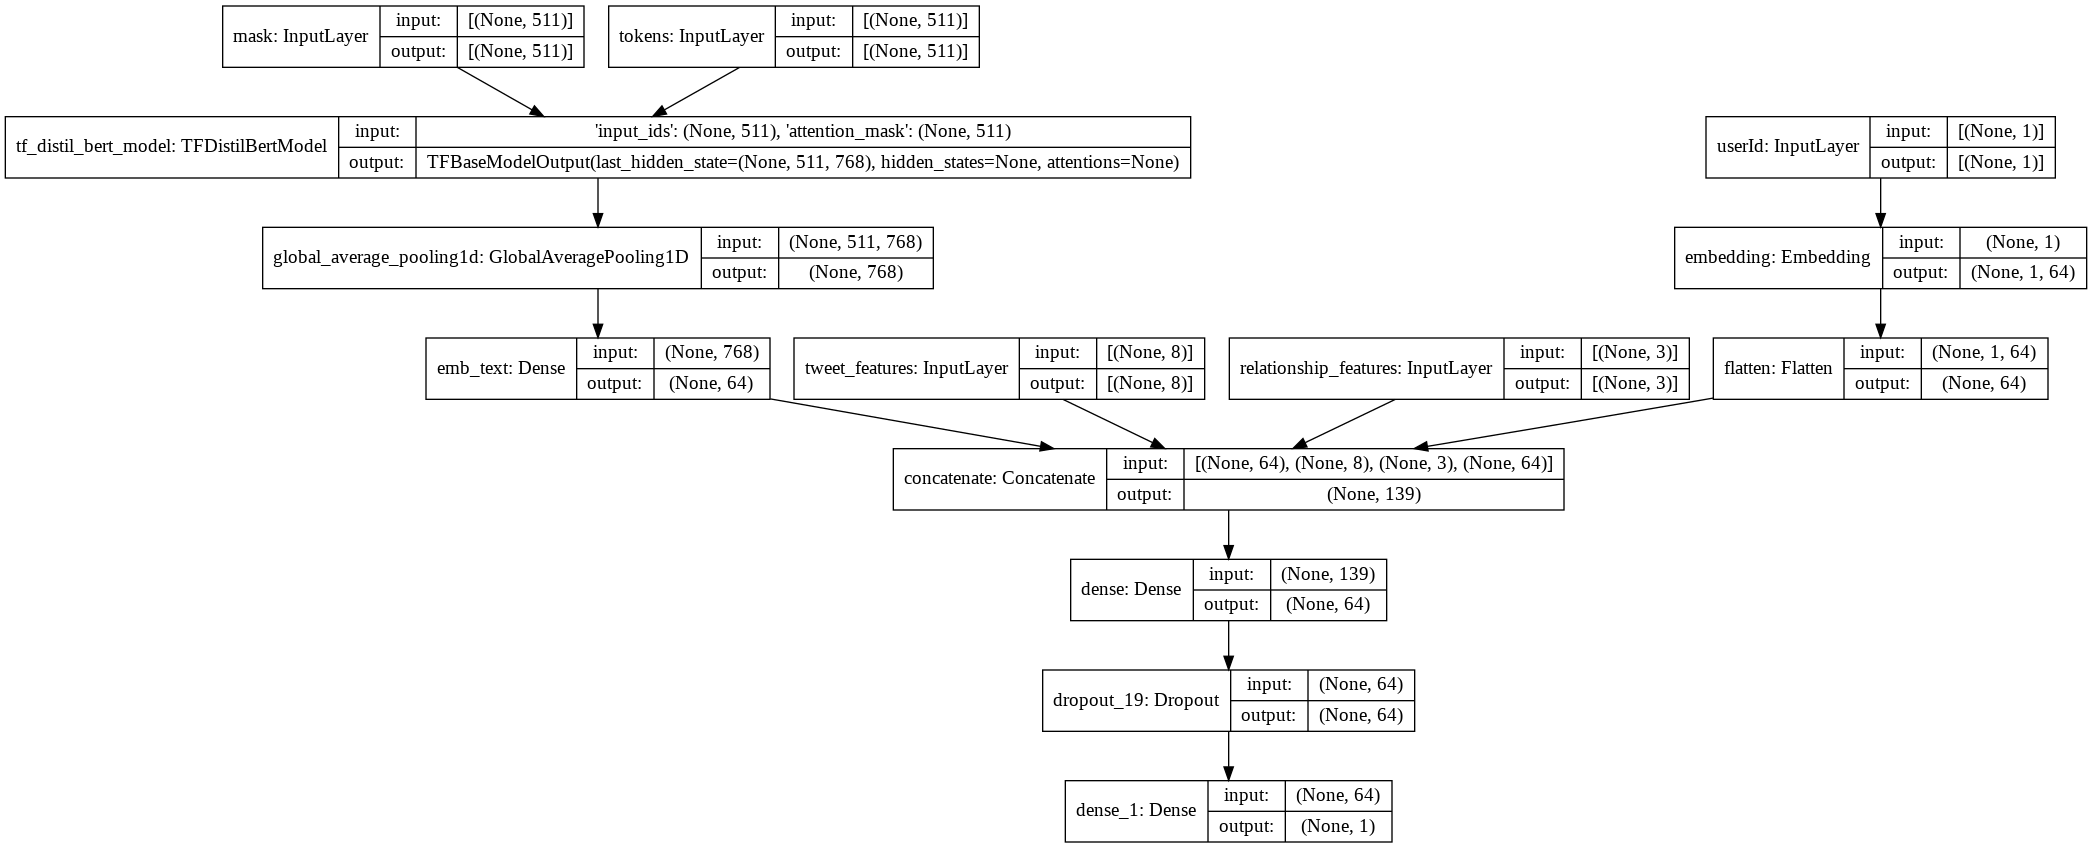

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

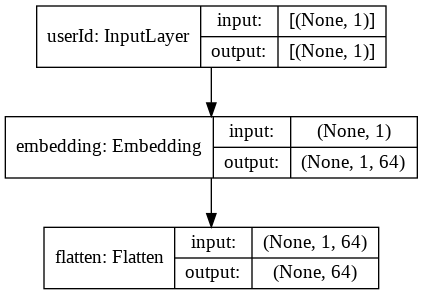

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
text=[101,3653,1291,102]+[0]*(NUM_TOKENS-4)
def att(token):
    return 0 if token==0 else 1
attention=[att(t) for t in text]

In [ ]:
model([tf.constant(text,shape=(1,NUM_TOKENS)),tf.constant(attention,shape=(1,NUM_TOKENS)),tf.constant([0]*NUM_FEATURES,shape=(1,NUM_FEATURES)),tf.constant([0]*REL_FEATURES,shape=(1,REL_FEATURES)),tf.constant(1,shape=(1,1))])
#model([tf.constant(text,shape=(1,NUM_TOKENS)),tf.constant([0]*NUM_FEATURES,shape=(1,NUM_FEATURES)),tf.constant([0]*REL_FEATURES,shape=(1,REL_FEATURES)),tf.constant([0]*EMB_SIZE,shape=(1,EMB_SIZE))])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48479447]], dtype=float32)>

In [ ]:
model2([tf.constant(0,shape=(1,1))])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]],
      dtype=float32)>

In [ ]:
model2([tf.constant(1,shape=(1,1))])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]],
      dtype=float32)>

###Model parameters

In [ ]:
import tensorflow.keras.backend as K

def create_weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
    return weighted_binary_crossentropy

In [ ]:
loss=create_weighted_binary_crossentropy(1, 3)
#loss=tf.keras.losses.BinaryCrossentropy()#   from_logits=True)
lr=0.0003
optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
train_acc_metric=tf.keras.metrics.AUC(curve="PR")
#train_acc_metric=tf.keras.metrics.BinaryCrossentropy(name="binary_crossentropy", dtype=None, from_logits=False, label_smoothing=0)
#train_acc_metric=tf.keras.metrics.MeanSquaredError()
#train_acc_metric=tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)
model.compile(loss=loss,optimizer=optimizer,metrics=train_acc_metric)

###Custom Dataset

####CreateDatasetObject

#####Single KerasCustomGenerator

In [ ]:
import numpy as np
import keras

class SingleDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,inputs, outputs,tweet_data_size,rel_data_size,num_tokens):
        'Initialization'
        self.inputs = inputs
        self.outputs = outputs
        self.length= len(inputs)
        self.tweet_data_size=tweet_data_size
        self.rel_data_size=rel_data_size
        self.num_tokens=num_tokens
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.length

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch

        # Find list of IDs

        # Generate data
        X, y = self.__data_generation(index)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        text_batch = np.empty((self.num_tokens))
        mask = np.empty((self.num_tokens))
        tweet = np.empty((self.tweet_data_size))
        rel = np.empty((self.rel_data_size))
        id = np.empty((1))
        y = np.empty((1), dtype=np.float32)

        # Generate data
        for i in [indexes]:
            row=self.inputs[i]
            text=row[0]
            
            pad=self.num_tokens-len(text)
            att=([1]*len(text))+[0]*(pad)
            text=text+([0]*(pad))

            feats=[*row[1:9]]
            relations=[*row[9:12]]
            user=row[12]
            i-=indexes[0]
            # Store sample
            text_batch = np.array(text)
            mask=np.array(att)
            tweet=np.array(feats)
            rel=np.array(relations)
            id=np.array(user)

            # Store class
            y[0] = self.outputs[i]

        return (text_batch,mask,tweet,rel,id), y

#####KerasCustomGenerator

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,inputs, outputs,tweet_data_size,rel_data_size,num_tokens, batch_size=32):
        'Initialization'
        self.batch_size = batch_size
        self.inputs = inputs
        self.outputs = outputs
        self.length= len(inputs)
        self.tweet_data_size=tweet_data_size
        self.rel_data_size=rel_data_size
        self.num_tokens=num_tokens
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.length / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = range(index*self.batch_size,(index+1)*self.batch_size)

        # Find list of IDs

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        text_batch = np.empty((self.batch_size,self.num_tokens))
        mask = np.empty((self.batch_size,self.num_tokens))
        tweet = np.empty((self.batch_size,self.tweet_data_size))
        rel = np.empty((self.batch_size,self.rel_data_size))
        id = np.empty((self.batch_size,1))
        y = np.empty((self.batch_size), dtype=np.float32)

        # Generate data
        for i in indexes:
            row=self.inputs[i]
            text=row[0]
            
            pad=self.num_tokens-len(text)
            att=([1]*len(text))+[0]*(pad)
            text=text+([0]*(pad))

            feats=[*row[1:9]]
            relations=[*row[9:12]]
            user=row[12]
            i-=indexes[0]
            # Store sample
            text_batch[i,] = np.array(text)
            mask[i,]=np.array(att)
            tweet[i,]=np.array(feats)
            rel[i,]=np.array(relations)
            id[i,]=np.array(user)

            # Store class
            y[i] = self.outputs[i]

        return (text_batch,mask,tweet,rel,id), y

##Training

###Fit

In [ ]:
gc.collect()

In [ ]:
BATCH_SIZE=128

In [ ]:
training_generator = DataGenerator(input[:len(input)], target[:len(input)],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)
test_generator = DataGenerator(inputTest[:len(inputTest)], targetTest[:len(inputTest)],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)

In [ ]:
training_generator.__getitem__(1)[0][0][0][0]

In [ ]:
model.fit(training_generator,epochs=1)

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.fit(training_generator,epochs=1)

In [ ]:
model.evaluate(test_generator)

In [ ]:
model2([tf.constant(0,shape=(1,1))])

In [ ]:
model2([tf.constant(1,shape=(1,1))])

###Try using sequence to get a tf.dataset

In [ ]:
BATCH_SIZE=128

In [ ]:
training_generator=SingleDataGenerator(input[:len(input)//10], target[:len(input)//10],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS)
data_iter = lambda: (s for s in training_generator )


# then you can use tf.data.Dataset.from_generator
dataset_tf = tf.data.Dataset.from_generator(
    data_iter,
    output_signature=(
                        (
                        tf.TensorSpec(shape=(511,), dtype=tf.float32),
                        tf.TensorSpec(shape=(511,), dtype=tf.float32),
                        tf.TensorSpec(shape=(training_generator.tweet_data_size,), dtype=tf.float32),
                        tf.TensorSpec(shape=(training_generator.rel_data_size,), dtype=tf.float32),
                        tf.TensorSpec(shape=(1,), dtype=tf.int32)
                        ),
                    tf.TensorSpec(shape=(1,), dtype=tf.float32, name='input_4')
                    ))

# now you can add a prefetch option that builds the next batch ready for consumption by the GPU as it is working on the current batch.
#dataset_tf = dataset_tf.prefetch(1)

NameError: ignored

In [ ]:
dataset_tf = dataset_tf.batch(BATCH_SIZE)

dataset_tf = dataset_tf.repeat()

In [ ]:
dataset_tf.take(1)

In [ ]:
gc.collect()

In [ ]:
import math

In [ ]:
steps=math.floor(len(training_generator)/BATCH_SIZE)

In [ ]:
model.fit(dataset_tf,steps_per_epoch=steps)

###batched generator version

In [ ]:
BATCH_SIZE=64

In [ ]:
training_generator = DataGenerator(input[:len(input)//2], target[:len(input)//2],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)

data_iter = lambda: (s for s in training_generator )

dataset_tf = tf.data.Dataset.from_generator(
    data_iter,
    output_signature=(
                        (
                        tf.TensorSpec(shape=(BATCH_SIZE,511), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,511), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,training_generator.tweet_data_size), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,training_generator.rel_data_size), dtype=tf.float32),
                        tf.TensorSpec(shape=(BATCH_SIZE,1), dtype=tf.int32)
                        ),
                    tf.TensorSpec(shape=(BATCH_SIZE), dtype=tf.float32, name='input_4')
                    ))
dataset_tf = dataset_tf.prefetch(2)

In [ ]:
steps=len(training_generator)

In [ ]:
steps

741

In [ ]:
gc.collect()

272

In [ ]:
model.fit(dataset_tf,steps_per_epoch=steps)

741/741 [==============================] - 1710s 2s/step - loss: 0.6967 - auc: 0.5009


In [ ]:
test_generator = DataGenerator(inputTest[:len(inputTest)], targetTest[:len(inputTest)],tweet_data_size=NUM_FEATURES,rel_data_size=REL_FEATURES,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)


In [ ]:
model.evaluate(test_generator)

369/369 [==============================] - 447s 1s/step - loss: 0.6907 - auc: 0.5023


[0.6906828284263611, 0.5022758841514587]

In [ ]:
model.fit(dataset_tf,steps_per_epoch=steps)

741/741 [==============================] - 1708s 2s/step - loss: 0.6786 - auc: 0.6051


In [ ]:
model.evaluate(test_generator)

369/369 [==============================] - 445s 1s/step - loss: 0.6939 - auc: 0.5113


[0.6939453482627869, 0.5113154053688049]

In [ ]:
!kill -9 -1

###Custom Training loop

In [ ]:
@tf.function
def trainStep(text,att,features,rel,user,out):
    with tf.GradientTape() as tape:
        logits = model([text,att,features,rel,user], training=True)  # Logits for this minibatch
        loss_value = loss(out, logits)
            
    train_acc_metric.update_state(out, logits)
        
    grad = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grad, model.trainable_weights))
    return logits

In [ ]:
gc.collect()

28106

In [ ]:
epochs = 10
loss_value=10
train_dataset=DatasetFixed(input,target)
for epoch in range(epochs):
    train_acc_metric.reset_states()
    if loss_value<=0.01:
                break
    print("\nStart of epoch %d" % (epoch,))
    for step, (text,att,features,rel,engaged_Id,out) in enumerate(train_dataset):
        logits=trainStep(text,att,features,rel,engaged_Id,out)
        if step % 100 == 0:
            #print(model2(engaged_Id).numpy())
            train_acc = train_acc_metric.result()
            print(f"Training abs error at step {step}: {train_acc}")
            print(f"target{out.numpy()} => predict {logits.numpy()}")
            gc.collect()
    train_acc = train_acc_metric.result()
    print(f"Training abs error over epoch {epoch}: {train_acc}")
    train_acc_metric.reset_states()


Start of epoch 0
Training abs error at step 0: 0.48795750737190247
target[[0.]] => predict [[0.4879575]]
Training abs error at step 100: 0.4684427082538605
target[[1.]] => predict [[0.33095264]]
Training abs error at step 200: 0.4653521478176117
target[[0.]] => predict [[0.74113363]]
Training abs error at step 300: 0.47499024868011475
target[[1.]] => predict [[0.2997694]]
Training abs error at step 400: 0.4641820788383484
target[[1.]] => predict [[0.34601104]]
Training abs error at step 500: 0.46867963671684265
target[[1.]] => predict [[0.4215265]]
Training abs error at step 600: 0.4710558354854584
target[[0.]] => predict [[0.6465208]]
Training abs error at step 700: 0.4764944612979889
target[[0.]] => predict [[0.5367392]]
Training abs error at step 800: 0.4795038402080536
target[[0.]] => predict [[0.77697635]]


KeyboardInterrupt: ignored